<a href="https://colab.research.google.com/github/gitarthasarma/Computer-Vision-Projects/blob/main/1_Image_classification_using_CNN_on_CIFAR10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import all required libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

#Data Preparation

The CIFAR10 dataset consists of 60000 32x32 px colour images in 10 classes.

###Downloading the data

In [ ]:
from torchvision.datasets.utils import download_url

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, ".")

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
# extracting the tar file
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = "./data")

data_dir = "./data/cifar10"

#checking the contents
print(os.listdir(data_dir))

#list of classes
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['cat', 'automobile', 'truck', 'dog', 'horse', 'bird', 'ship', 'deer', 'frog', 'airplane']


In [ ]:
# number of training examples
print(len(os.listdir(data_dir + "/train/horse")))

#number of test examples
print(len(os.listdir(data_dir + "/test/horse")))

5000
1000


###Preparing the datasets

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir + "/train", transform = ToTensor())


In [ ]:
img, label = dataset[0]

print(img.shape)
print(label)

torch.Size([3, 32, 32])
0


In [ ]:
#list of classes is stored in .classes attribute of dataset
print(dataset.classes)  #label refers to the index in the list

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Label: airplane (0)


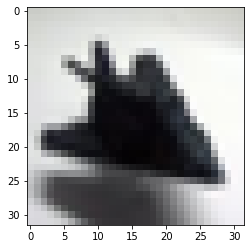

In [ ]:
# viewing a sample
def show_example(img, label):
  print(f"Label: {dataset.classes[label]} ({label})")
  plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[0])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 5_000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

###Preparing the dataloaders

In [ ]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


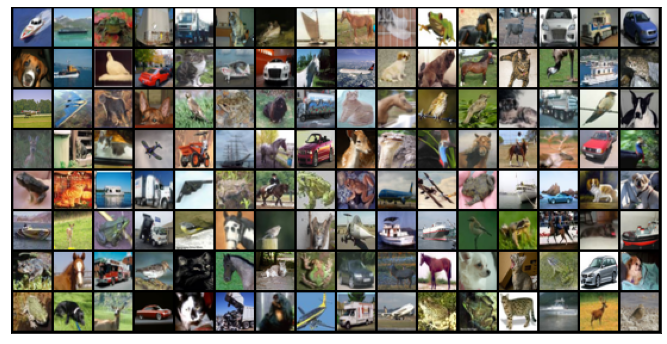

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

show_batch(train_dl)

#Creating the Network

In [ ]:
# base class containing helper methods
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
    
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss.detach(), "val_acc": acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print(f"""
    Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: \
    {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}""")


def accuracy(output, labels):
  _, preds = torch.max(output, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,32),
            nn.ReLU(),
            nn.Linear(32, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

#Transferring the model to CUDA GPU(if available)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

#Training the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
  model.eval
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training phase
    model.train()
    train_losses = []
    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    # Validation phase
    result = evaluate(model, val_dl)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
#hyperparameters
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



    Epoch [0], train_loss: 0.7221, val_loss:     0.8714, val_acc: 0.6980

    Epoch [1], train_loss: 0.6306, val_loss:     0.7970, val_acc: 0.7326

    Epoch [2], train_loss: 0.5445, val_loss:     0.8055, val_acc: 0.7368

    Epoch [3], train_loss: 0.4707, val_loss:     0.8031, val_acc: 0.7502

    Epoch [4], train_loss: 0.3970, val_loss:     0.8383, val_acc: 0.7487


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

#Testing the model on new data

In [1]:
def predict_image(image, model):
  # convert to batch of size 1
  x = to_device(image.unsqueeze(0), device)

  # get output from model
  output = model(image)

  # pick the index with largest element
  _, pred = torch.max(output, dim=1)
  return dataset.classes[pred[0]]


In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result